In [138]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

In [140]:
# Collect tickers from SP 500 index
ticker_df2 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
tickers = ticker_df2.Symbol.to_list()

In [141]:
# Define start date
start_date = '2010-01-01'

In [142]:
# Download historical data for each ticker
dfPrices = yf.download(tickers, start = start_date)['Adj Close']

[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
- BRK.B: No data found for this date range, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted


In [143]:
dfPrices.reset_index(inplace=True)
dfPrices = dfPrices.set_index('Date')
# Drop tickers with missing data. Diminish survivorship bias
dfPrices = dfPrices.dropna(axis=1)

In [144]:
# Calculate monthly returns
dfReturnsMtl = (dfPrices.pct_change() +1)[1:].resample('M').prod()

In [145]:
# Function to calculate the n monthly returns
def get_rolling_returns(df, months):
    return df.rolling(months).apply(np.prod)

In [146]:
# Calculate the 12, 6, and 3 month returns
ret_12, ret_6, ret_3 = get_rolling_returns(dfReturnsMtl, 12), get_rolling_returns(dfReturnsMtl, 6), get_rolling_returns(dfReturnsMtl, 3)

In [150]:
# Get top as function of date
def get_top(date):
    top_50 = ret_12.loc[date].nlargest(50).index
    top_30 = ret_6.loc[date].loc[top_50].nlargest(30).index
    top_10 = ret_3.loc[date].loc[top_30].nlargest(10).index
    return top_10

In [151]:
# Get bottom as function of date
def get_bottom(date):
    bottom_50 = ret_12.loc[date].nsmallest(50).index
    bottom_30 = ret_6.loc[date].loc[bottom_50].nsmallest(30).index
    bottom_10 = ret_3.loc[date].loc[bottom_30].nsmallest(10).index
    return bottom_10

In [156]:
# Get random tickers each month
def get_random(date):
    random_50 = ret_12.loc[date].sample(50).index
    random_30 = ret_6.loc[date].loc[random_50].sample(30).index
    random_10 = ret_3.loc[date].loc[random_30].sample(10).index
    return random_10

In [157]:
# Performance of portfolio
def get_portfolio_performance(date):
    portfolio = dfReturnsMtl.loc[date:,get_top(date)][1:2]
    return portfolio.mean().values[0]

In [158]:
# Performace of worst picks
def get_worst_performance(date):
    worst = dfReturnsMtl.loc[date:,get_bottom(date)][1:2]
    return worst.mean().values[0]

In [159]:
# Performance of random picks
def get_random_performance(date):
    random = dfReturnsMtl.loc[date:,get_random(date)][1:2]
    return random.mean().values[0]

In [160]:
# Backtest the strategy
returns = []
for date in dfReturnsMtl.index[:-1]:
    returns.append(get_portfolio_performance(date))

worst_returns = []
for date in dfReturnsMtl.index[:-1]:
    worst_returns.append(get_worst_performance(date))

random_returns = []
for date in dfReturnsMtl.index[:-1]:
    random_returns.append(get_random_performance(date))

dfStrat = pd.Series(returns, index=dfReturnsMtl.index[:-1]).cumprod()
dfWorst = pd.Series(worst_returns, index=dfReturnsMtl.index[:-1]).cumprod()
dfRandom = pd.Series(random_returns, index=dfReturnsMtl.index[:-1]).cumprod()

# Compare to index
dfIndex = yf.download('SPY', start = start_date)['Adj Close']
# Calculate and plot returns of Index
dfIndexMtl = (dfIndex.pct_change() +1).cumprod()

[*********************100%***********************]  1 of 1 completed


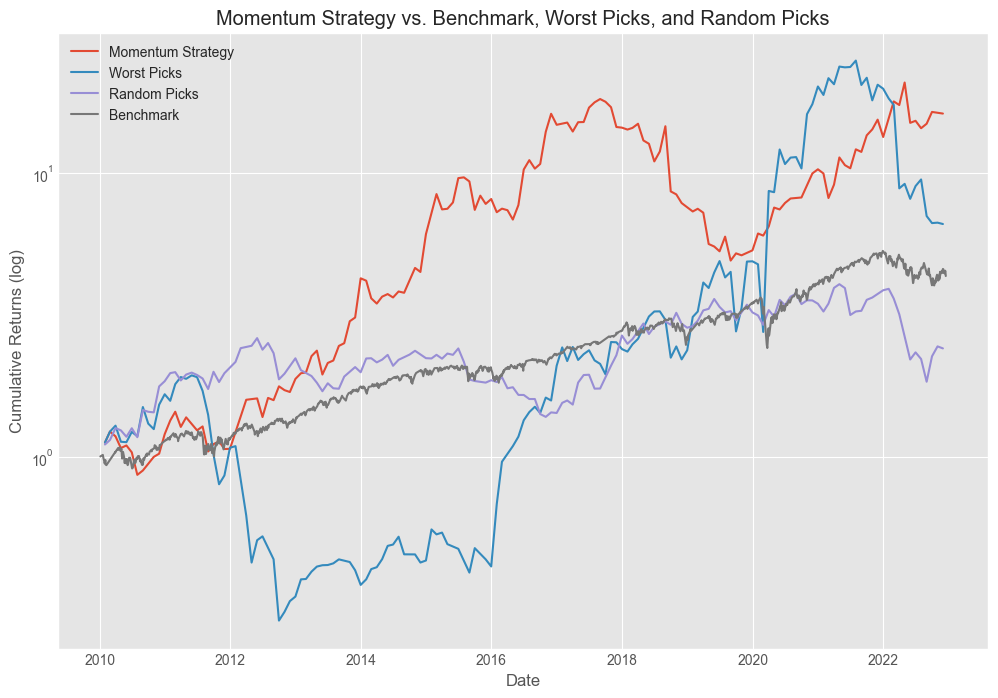

In [179]:
# Plot the results
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.title('Momentum Strategy vs. Benchmark, Worst Picks, and Random Picks')
plt.plot(dfStrat, label='Momentum Strategy')
plt.plot(dfWorst, label='Worst Picks')
plt.plot(dfRandom, label='Random Picks')
plt.plot(dfIndexMtl, label='Benchmark')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns (log)')
plt.yscale('log')
plt.legend()
plt.show()